In [1]:
import IPython.display as ipd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import os

from dataloaders import ImageCaptionDataset, ImageCaptionDatasetHDF5
from run_unit_analysis import (load_dataset, get_word_ali, get_code_ali,
                               prepare_data, STOP_WORDS, comp_code_to_wordprec,
                               comp_word_to_coderecall)
from run_utils import load_audio_model_and_state
from steps.plot import (load_raw_spectrogram, plot_spec_and_alis,
                        plot_precision_recall, plot_num_words_above_f1_threshold)
from steps.unit_analysis import (print_code_to_word_prec, print_word_by_code_recall,
                                 comp_code_word_f1, print_code_stats_by_f1, 
                                 print_word_stats_by_f1, count_high_f1_words,
                                 compute_topk_avg_f1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load data
json_path = './filelist/train_original_with_alignments.json'
hdf5_path = '/data/sls/temp/wnhsu/data/mm/places_hdf5/PlacesEnglish400kTrain.json'

# This is an alternative to ImageCaptionDatasetHDF5, which computes audio
# features on the fly. It might be much slower due to intense data I/O.
# dataset = ImageCaptionDataset(json_path)

dataset = ImageCaptionDatasetHDF5(hdf5_path)
with open(json_path) as f:
    json_data_basis = json.load(f)
    json_data = json_data_basis['data']
    audio_base = json_data_basis.get('audio_base_path', '')
    image_base = json_data_basis.get('image_base_path', '')

In [3]:
# load model
exp_dir = './exps/pretrained/RDVQ_01000_01100_01110'
audio_model = load_audio_model_and_state(exp_dir=exp_dir)
audio_model = audio_model.to(device)
audio_model = audio_model.eval()

print('Successfully loaded dataset and model at %s' % time.asctime())

Successfully loaded dataset and model at Wed Jun  3 23:47:05 2020


In [4]:
def get_detection_stats(audio_model, layer, dataset, json_data, max_n_utts,
                        code_halfwidth=0.04, stop_words=STOP_WORDS, min_occ=1):
    utt2codes, utt2words = prepare_data(audio_model, layer, dataset, json_data, max_n_utts)
    c2wp = comp_code_to_wordprec(utt2codes, utt2words, code_halfwidth, stop_words)
    w2cr = comp_word_to_coderecall(utt2codes, utt2words, [])
    c2wf, w2cf = comp_code_word_f1(c2wp, w2cr, min_occ=min_occ)
    return c2wp, w2cr, c2wf, w2cf

### Visualize alignment

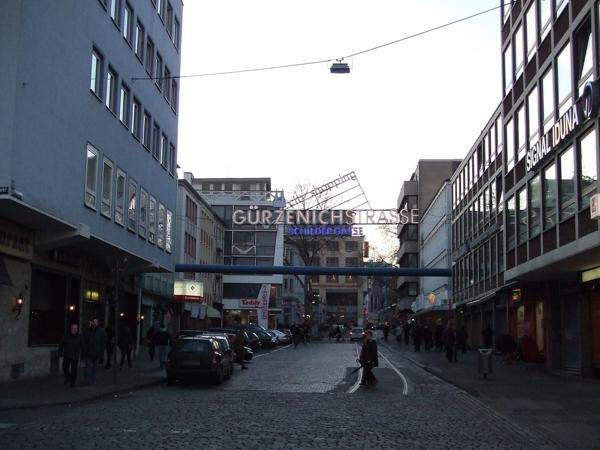

the large view of the city street there are many people walking around the street


In [5]:
# Show one example in the dataset
utt_index = 5
wav_path = os.path.join(audio_base, json_data[utt_index]['wav'])
img_path = os.path.join(image_base, json_data[utt_index]['image'])
ipd.display(ipd.Audio(wav_path))
ipd.display(ipd.Image(img_path))

if 'text' in json_data[0]:
    text = json_data[utt_index]['text']
else:
    text = json_data[utt_index]['asr_text']
print(text)

In [6]:
# Show time-aligned transcripts for words and codes
word_ali = get_word_ali(json_data, utt_index)
code_q4_ali = get_code_ali(audio_model, 'quant4', dataset, utt_index, device).get_sparse_ali()
code_q3_ali = get_code_ali(audio_model, 'quant3', dataset, utt_index, device).get_sparse_ali()
code_q2_ali = get_code_ali(audio_model, 'quant2', dataset, utt_index, device).get_sparse_ali()

print('\n##### Time-aligned word transcripts #####')
for t_s, t_e, lab in word_ali.data:
    print('%5.2f %5.2f %s' % (t_s, t_e, lab))

print('\n##### Time-aligned VQ4 transcripts #####')
for t_s, t_e, lab in code_q4_ali.data:
    print('%5.2f %5.2f %s' % (t_s, t_e, lab))

Loading audio from /data/sls/temp/wnhsu/data/mm/places_hdf5/PlacesEnglish400kTrain_audio.hdf5

##### Time-aligned word transcripts #####
 0.16  0.38 THE
 0.38  0.85 LARGE
 0.85  1.04 VIEW
 1.04  1.13 OF
 1.13  1.21 THE
 1.21  1.54 CITY
 1.54  1.96 STREET
 2.04  2.21 THERE
 2.21  2.25 ARE
 2.25  2.52 MANY
 2.52  2.85 PEOPLE
 2.85  3.22 WALKING
 3.22  3.51 AROUND
 3.51  3.58 THE
 3.58  3.96 STREET

##### Time-aligned VQ4 transcripts #####
 0.00  0.24 169
 0.24  0.40 313
 0.40  0.48 122
 0.48  0.80 32
 0.80  1.12 932
 1.12  1.52 88
 1.52  2.00 336
 2.00  2.08 254
 2.08  2.16 818
 2.16  2.24 418
 2.24  2.40 228
 2.40  2.48 540
 2.48  2.80 10
 2.80  2.88 540
 2.88  3.28 160
 3.28  3.44 500
 3.44  3.52 254
 3.52  3.92 336
 3.92  4.08 254
 4.08  4.16 81
 4.16  4.48 881
 4.48  4.56 81
 4.56  4.72 654


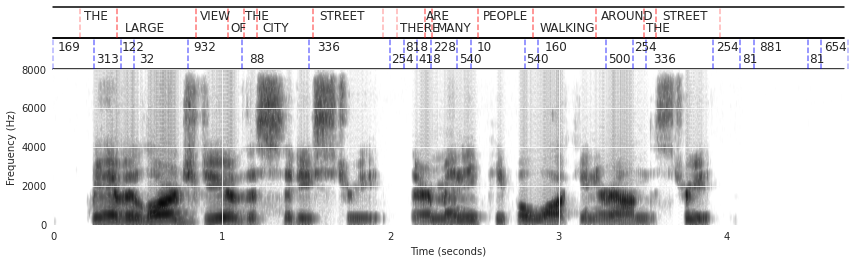

In [7]:
# Plot spectrogram and multiple time-aligned transcripts
plot_spec_and_alis(wav_path, [code_q4_ali, word_ali], figsize=(12, 4))

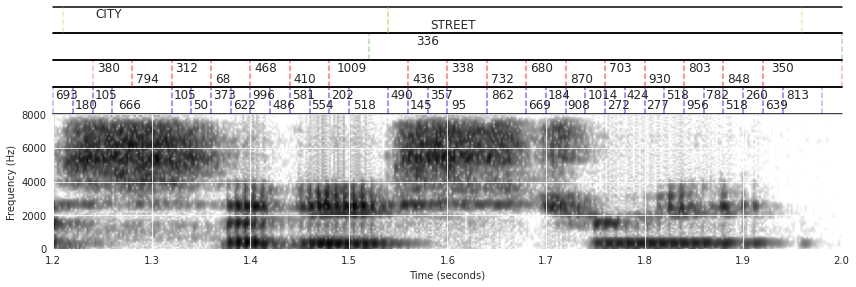

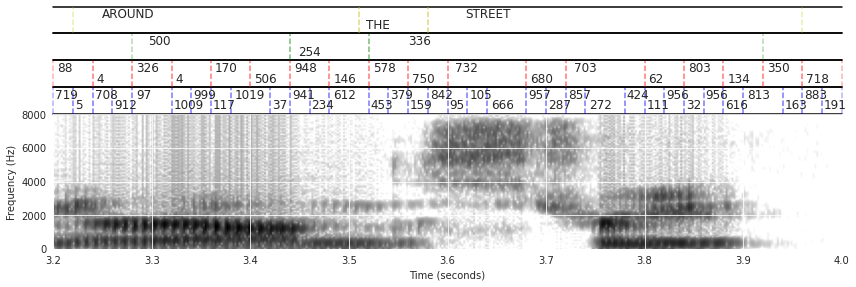

In [8]:
# Plot a segment of spectrogram and time-aligned transcripts
plot_spec_and_alis(wav_path, [code_q2_ali, code_q3_ali, code_q4_ali, word_ali],
                   seg_s=1.2, seg_e=2, figsize=(12, 6))

plot_spec_and_alis(wav_path, [code_q2_ali, code_q3_ali, code_q4_ali, word_ali],
                   seg_s=3.2, seg_e=4, figsize=(12, 6))

Utterance index=5424, segment range=(2.59, 4.59)


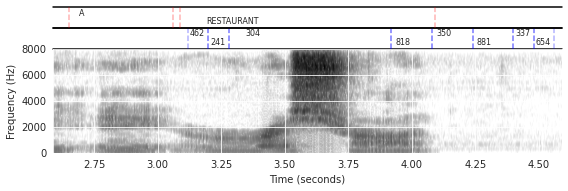

Utterance index=1630, segment range=(0.88, 2.53)


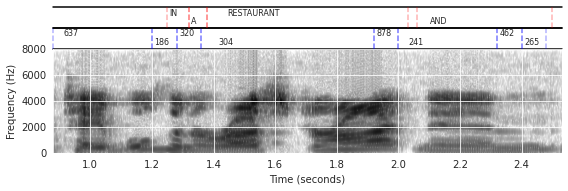

Utterance index=1632, segment range=(0.66, 2.38)


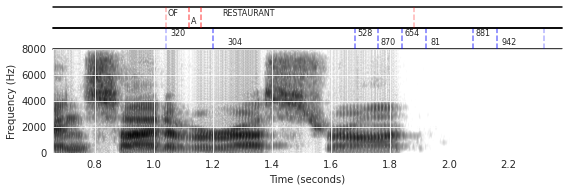

Utterance index=7041, segment range=(1.25, 2.87)


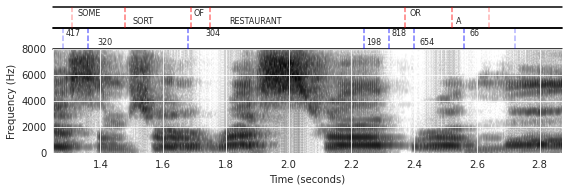

Utterance index=8473, segment range=(3.38, 5.04)


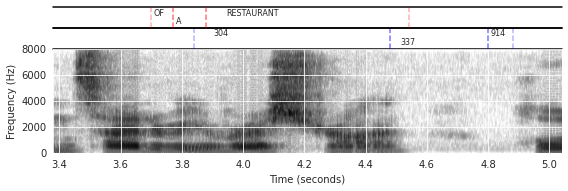

In [9]:
# Find segments by keyword
def find_seg_by_keyword(json_data, keyword, max_num=10):
    ret = []  # (utt_index, seg_s, seg_e)
    utt_index = 0
    while len(ret) < max_num and utt_index < len(json_data):
        word_ali = get_word_ali(json_data, utt_index)
        if word_ali is not None:
            for seg_s, seg_e, word in word_ali.data:
                if word.lower() == keyword.lower():
                    ret.append((utt_index, seg_s, seg_e))
        utt_index += 1
    return ret


keyword = 'RESTAURANT'

segs = find_seg_by_keyword(json_data, keyword, 100)
np.random.shuffle(segs)

for utt_index, seg_s, seg_e in segs[:5]:
    wav_path = os.path.join(audio_base, json_data[utt_index]['wav'])
    word_ali = get_word_ali(json_data, utt_index)
    code_q4_ali = get_code_ali(audio_model, 'quant4', dataset, utt_index, device).get_sparse_ali()
    
    seg_s, seg_e = max(seg_s-0.5, 0), seg_e+0.5
    print('Utterance index=%d, segment range=(%.2f, %.2f)' % (utt_index, seg_s, seg_e))
    
    plot_spec_and_alis(wav_path, [code_q4_ali, word_ali], seg_s, seg_e, fontsize=8, figsize=(8, 3))
    ipd.display(ipd.Audio(wav_path))

### Quantitative evaluation for word detection
This part significantly overlaps with `run_unit_analysis.py`

In [10]:
max_n_utts = 20000
layer = 'quant4'

c2wp, w2cr, c2wf, w2cf = get_detection_stats(audio_model, layer, dataset, json_data, max_n_utts)
ipd.clear_output()

In [11]:
print_code_stats_by_f1(c2wf, range(50), num_word_show=1)

##### Showing ranks range(0, 50)
 rk & code &       word &     F1 &   Prec & Recall &   Occ
  1 &  962 &  courtyard &  91.91 &  93.73 &  90.16 &    55 \\
  2 &  412 &     pantry &  90.97 &  86.89 &  95.45 &    42 \\
  3 &  105 &    nursery &  90.14 &  85.23 &  95.65 &    22 \\
  4 &  386 & background &  89.66 &  87.28 &  92.17 &   918 \\
  5 &  752 &      patio &  89.31 &  87.34 &  91.37 &   127 \\
  6 &  226 &      trees &  88.20 &  88.96 &  87.47 &  1298 \\
  7 &  712 &   graffiti &  88.07 &  84.38 &  92.11 &    35 \\
  8 &  298 &     studio &  87.99 &  84.23 &  92.11 &    35 \\
  9 &  577 &     desert &  87.26 &  83.59 &  91.26 &   188 \\
 10 &  422 &   concrete &  86.96 &  84.12 &  90.00 &   108 \\
 11 &   18 &    station &  86.82 &  81.50 &  92.89 &   209 \\
 12 &  562 &    gallery &  86.65 &  79.49 &  95.24 &    20 \\
 13 &  736 &   distance &  86.65 &  84.24 &  89.20 &   355 \\
 14 &  594 &    stadium &  86.61 &  82.61 &  91.01 &    81 \\
 15 &  464 &     church &  86.57 &  80.3

In [12]:
print_word_stats_by_f1(w2cf, range(50), num_code_show=1)

##### Showing ranks range(0, 50)
 rk &            word & code &     F1 &   Prec & Recall &   Occ
  1 &       courtyard &  962 &  91.91 &  93.73 &  90.16 &    55 \\
  2 &          pantry &  412 &  90.97 &  86.89 &  95.45 &    42 \\
  3 &         nursery &  105 &  90.14 &  85.23 &  95.65 &    22 \\
  4 &      background &  386 &  89.66 &  87.28 &  92.17 &   918 \\
  5 &           patio &  752 &  89.31 &  87.34 &  91.37 &   127 \\
  6 &           trees &  226 &  88.20 &  88.96 &  87.47 &  1298 \\
  7 &        graffiti &  712 &  88.07 &  84.38 &  92.11 &    35 \\
  8 &          studio &  298 &  87.99 &  84.23 &  92.11 &    35 \\
  9 &          desert &  577 &  87.26 &  83.59 &  91.26 &   188 \\
 10 &        concrete &  422 &  86.96 &  84.12 &  90.00 &   108 \\
 11 &         station &   18 &  86.82 &  81.50 &  92.89 &   209 \\
 12 &         gallery &  562 &  86.65 &  79.49 &  95.24 &    20 \\
 13 &        distance &  736 &  86.65 &  84.24 &  89.20 &   355 \\
 14 &         stadium &  594 &  

In [13]:
count_high_f1_words(w2cf, f1_threshold=0.5)
top_word_avg_f1 = compute_topk_avg_f1(w2cf, k=250)

254 / 9387 words with an F1 score >= 0.5
avg F1 = 69.36% for top 250 words; 4.40% for all 9352 words


### Compare models

In [14]:
# what models to inspect?
json_path = './filelist/train_original_with_alignments.json'
hdf5_path = '/data/sls/temp/wnhsu/data/mm/places_hdf5/PlacesEnglish400kTrain.json'

exp_dirs = ['./exps/pretrained/RDVQ_01000_01100',
            './exps/pretrained/RDVQ_00100_01100',]
layers = ['quant3',
          'quant3']
names = [r'"$\{2\} \rightarrow \{2, 3\}$" VQ3',
         r'"$\{3\} \rightarrow \{2, 3\}$" VQ3',]

In [15]:
max_n_utts = 20000
w2cf_list = []
for exp_dir, layer in zip(exp_dirs, layers):
    audio_model = load_audio_model_and_state(exp_dir=exp_dir)
    audio_model = audio_model.to(device)
    audio_model = audio_model.eval()
    print(time.asctime())
    
    _, _, _, w2cf = get_detection_stats(audio_model, layer, dataset, json_data, max_n_utts)
    w2cf_list.append(w2cf)
    
ipd.clear_output()

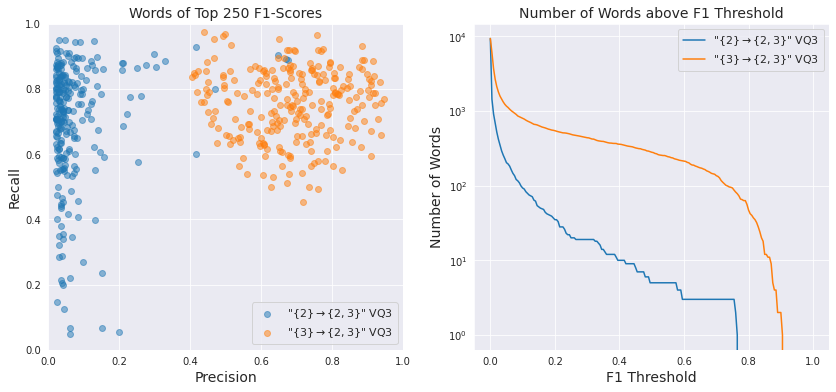

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

num_words = 250
f1_thresholds = np.linspace(0, 1, 201)
for w2cf in w2cf_list:
    plot_precision_recall(w2cf, num_words, axes[0])
    plot_num_words_above_f1_threshold(w2cf, f1_thresholds, axes[1])

axes[0].legend(names, fontsize=11)
axes[1].legend(names, fontsize=11)
plt.show()

In [17]:
# what models to inspect?
json_path = './filelist/train_original_with_alignments.json'
hdf5_path = '/data/sls/temp/wnhsu/data/mm/places_hdf5/PlacesEnglish400kTrain.json'

exp_dirs = ['./exps/pretrained/RDVQ_01000_01100_01110',
            './exps/pretrained/RDVQ_01000_01100_01110',
            './exps/pretrained/RDVQ_01000_01100_01110',]
layers = ['quant2',
          'quant3',
          'quant4',]
names = [r'"$\{2\} \rightarrow \{2, 3\} \rightarrow \{2, 3, 4\}$" VQ2',
         r'"$\{2\} \rightarrow \{2, 3\} \rightarrow \{2, 3, 4\}$" VQ3',
         r'"$\{2\} \rightarrow \{2, 3\} \rightarrow \{2, 3, 4\}$" VQ4',]

In [18]:
max_n_utts = 20000
w2cf_list = []
for exp_dir, layer in zip(exp_dirs, layers):
    audio_model = load_audio_model_and_state(exp_dir=exp_dir)
    audio_model = audio_model.to(device)
    audio_model = audio_model.eval()
    print(time.asctime())
    
    _, _, _, w2cf = get_detection_stats(audio_model, layer, dataset, json_data, max_n_utts)
    w2cf_list.append(w2cf)
    
ipd.clear_output()

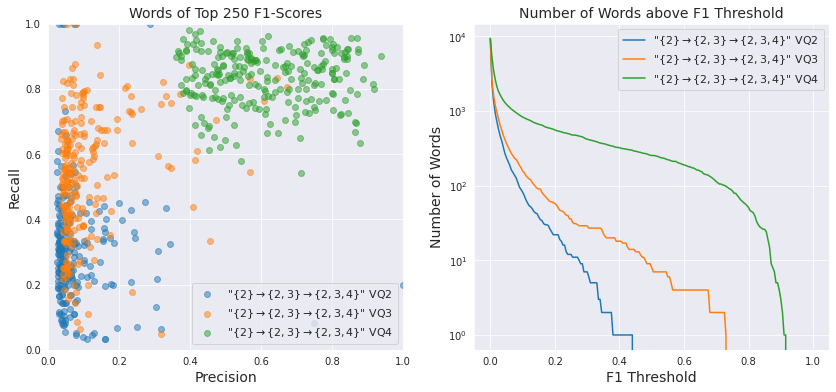

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

num_words = 250
f1_thresholds = np.linspace(0, 1, 201)
for w2cf in w2cf_list:
    plot_precision_recall(w2cf, num_words, axes[0])
    plot_num_words_above_f1_threshold(w2cf, f1_thresholds, axes[1])

axes[0].legend(names, fontsize=11)
axes[1].legend(names, fontsize=11)
plt.show()